In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Plotting functions

In [33]:
def plot_within_hour(df, year, month, day, hour, metric, devices):
    """
    Plots the specified metric over the specified hour for the given devices.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year of the hour to plot.
    - month (int): The month of the hour to plot.
    - day (int): The day of the hour to plot.
    - hour (int): The hour (in 24-hour format) to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.

    Returns:
    - None: Displays the plot.

    Raises:
    - ValueError: If any device in 'devices' is not found in the DataFrame.
    - ValueError: If the 'metric' is not present in the DataFrame.
    """

    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present in the DataFrame
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter for the specified devices
    df_filtered = df[df["label"].isin(devices)]

    # Create a datetime range for the specified hour
    start_time = pd.Timestamp(year, month, day, hour)
    end_time = start_time + pd.Timedelta(hours=1)

    # Filter the DataFrame for the specified hour
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    # Handle missing values in the metric column
    df_filtered = df_filtered.dropna(subset=[metric])

    # Plot the data
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_filtered, x="time", y=metric, hue="label", marker="o")

    # Set plot title and labels
    plt.title(f"{metric} over time on {year}-{month:02d}-{day:02d} Hour {hour:02d}")
    plt.xlabel("Time")
    plt.ylabel(metric.capitalize())

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Move the legend outside the plot
    plt.legend(title="Device Label", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_within_day(df, year, month, day, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each hour within the specified day.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - day (int): The day to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.

    Returns:
    - None: Displays the plot.
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by date
    start_time = pd.Timestamp(year, month, day)
    end_time = start_time + pd.Timedelta(days=1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])

    # Extract hour
    df_filtered["hour"] = df_filtered["time"].dt.hour

    # Group by hour and label
    df_grouped = (
        df_filtered.groupby(["hour", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["hour"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["hour"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )

    plt.title(f"{metric} over each hour on {year}-{month:02d}-{day:02d}")
    plt.xlabel("Hour")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(0, 24))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_month(df, year, month, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each day within the specified month.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.

    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by month
    start_time = pd.Timestamp(year, month, 1)
    if month == 12:
        end_time = pd.Timestamp(year + 1, 1, 1)
    else:
        end_time = pd.Timestamp(year, month + 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])

    # Extract day
    df_filtered["day"] = df_filtered["time"].dt.day

    # Group by day and label
    df_grouped = (
        df_filtered.groupby(["day", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["day"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["day"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )

    plt.title(f"{metric} over each day in {year}-{month:02d}")
    plt.xlabel("Day")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 32))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_year(df, year, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each month within the specified year.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.

    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by year
    start_time = pd.Timestamp(year, 1, 1)
    end_time = pd.Timestamp(year + 1, 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])

    # Extract month
    df_filtered["month"] = df_filtered["time"].dt.month

    # Group by month and label
    df_grouped = (
        df_filtered.groupby(["month", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["month"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["month"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )

    plt.title(f"{metric} over each month in {year}")
    plt.xlabel("Month")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 13))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Preprocessing

In [34]:
wifistats_df = pd.read_csv("./data/wifistats.csv")
extra_info_df = pd.read_csv("./data/extra_info.csv")
devices_df = pd.read_csv("./data/devices.csv")

df = pd.merge(wifistats_df, extra_info_df, on="label", how="inner")
df.head()

,label,time,signal (dBm),packet_loss,connected_time (s),tx_bitrate (MBit/s),rx_bitrate (MBit/s),min_ping_rtt (ms),avg_ping_rtt (ms),max_ping_rtt (ms),mdev_ping_rtt (ms),latitude,longitude
0,raspi-e4:5f:01:a0:50:5f,2024-10-06 01:19:52.908003,-52.0,0.0,990597.0,180.0,200.0,4.463,4.868,5.433,0.324,34.41272,-119.852482
1,raspi-e4:5f:01:a0:50:5f,2024-10-06 01:30:08.707347,-52.0,0.0,991209.0,162.0,200.0,4.083,4.370,4.640,0.189,34.41272,-119.852482
2,raspi-e4:5f:01:a0:50:5f,2024-10-06 01:40:24.494088,-51.0,0.0,991822.0,162.0,200.0,3.759,5.936,6.834,1.129,34.41272,-119.852482
3,raspi-e4:5f:01:a0:50:5f,2024-10-06 01:50:40.320886,-51.0,0.0,992435.0,180.0,200.0,3.804,4.560,6.302,0.896,34.41272,-119.852482
4,raspi-e4:5f:01:a0:50:5f,2024-10-06 02:00:56.877177,-52.0,0.0,993049.0,200.0,200.0,3.418,3.986,4.496,0.371,34.41272,-119.852482


# Example

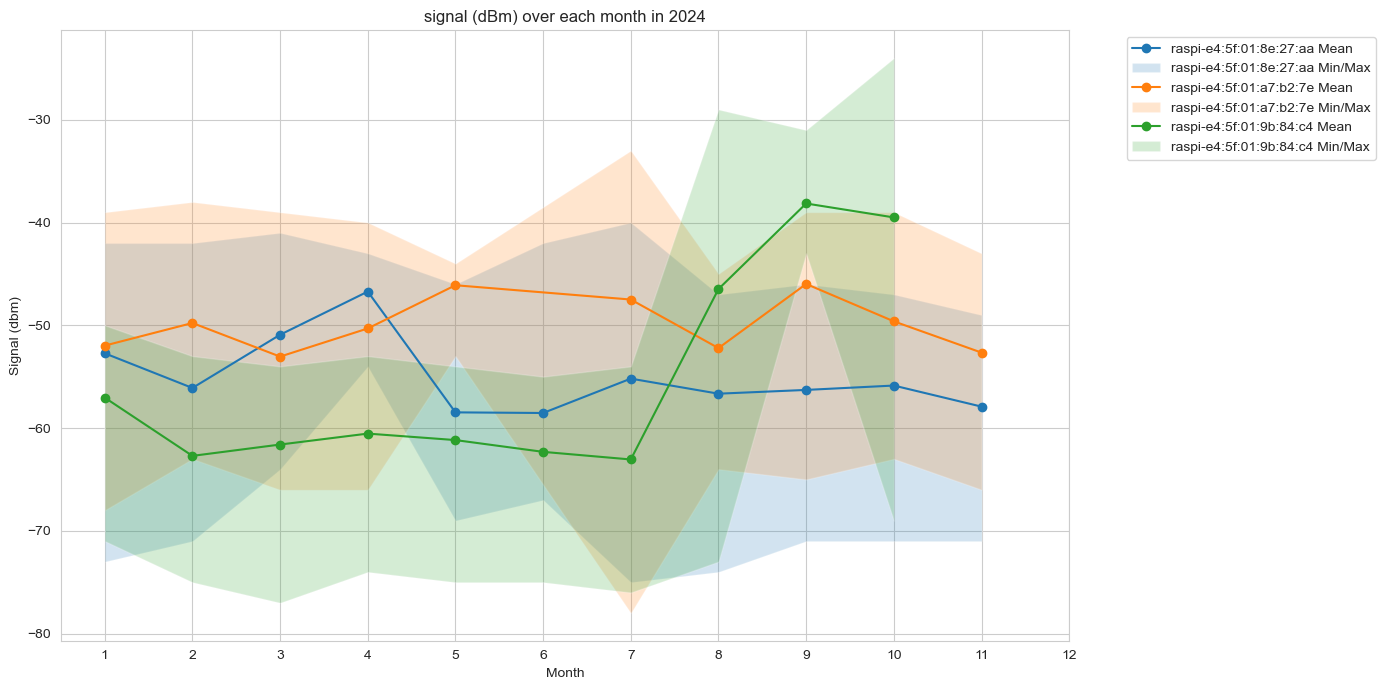

In [35]:
# signal strength over time in 2024
plot_within_year(
    df,
    2024,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)

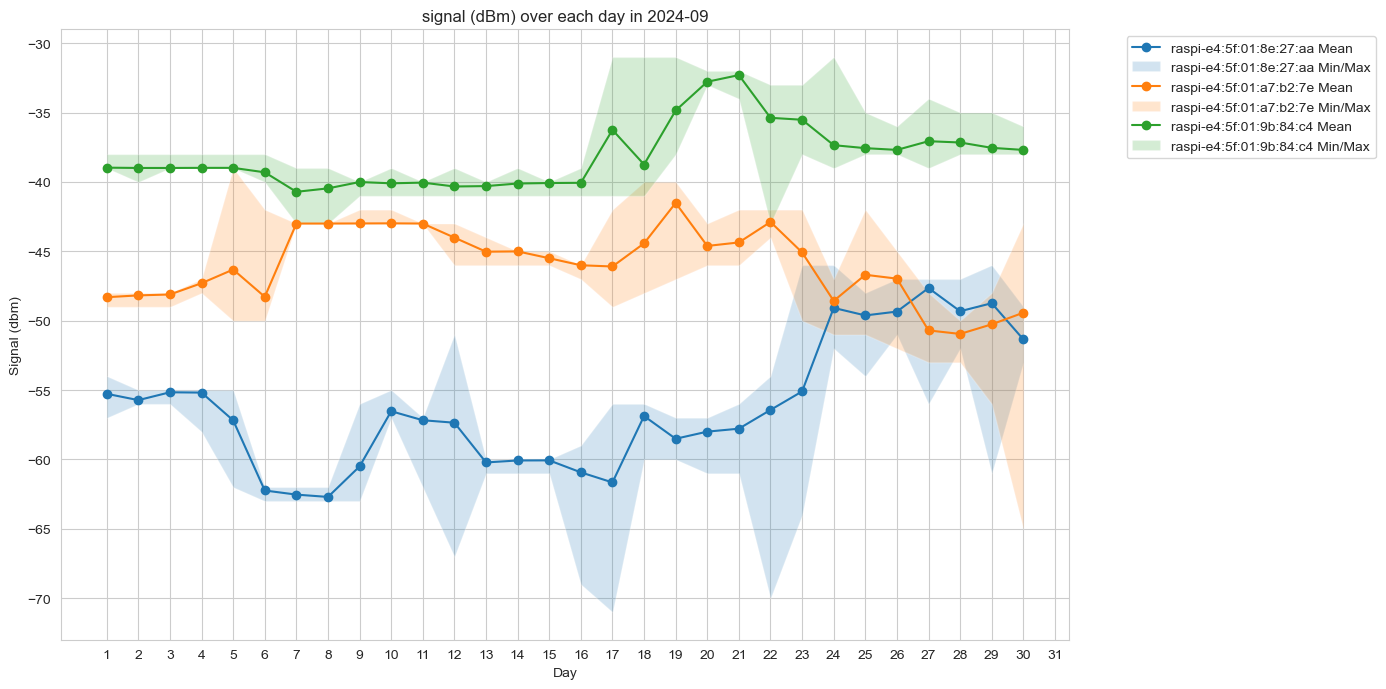

In [36]:
# signal strength over time in the September, 2024
plot_within_month(
    df,
    2024,
    9,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)

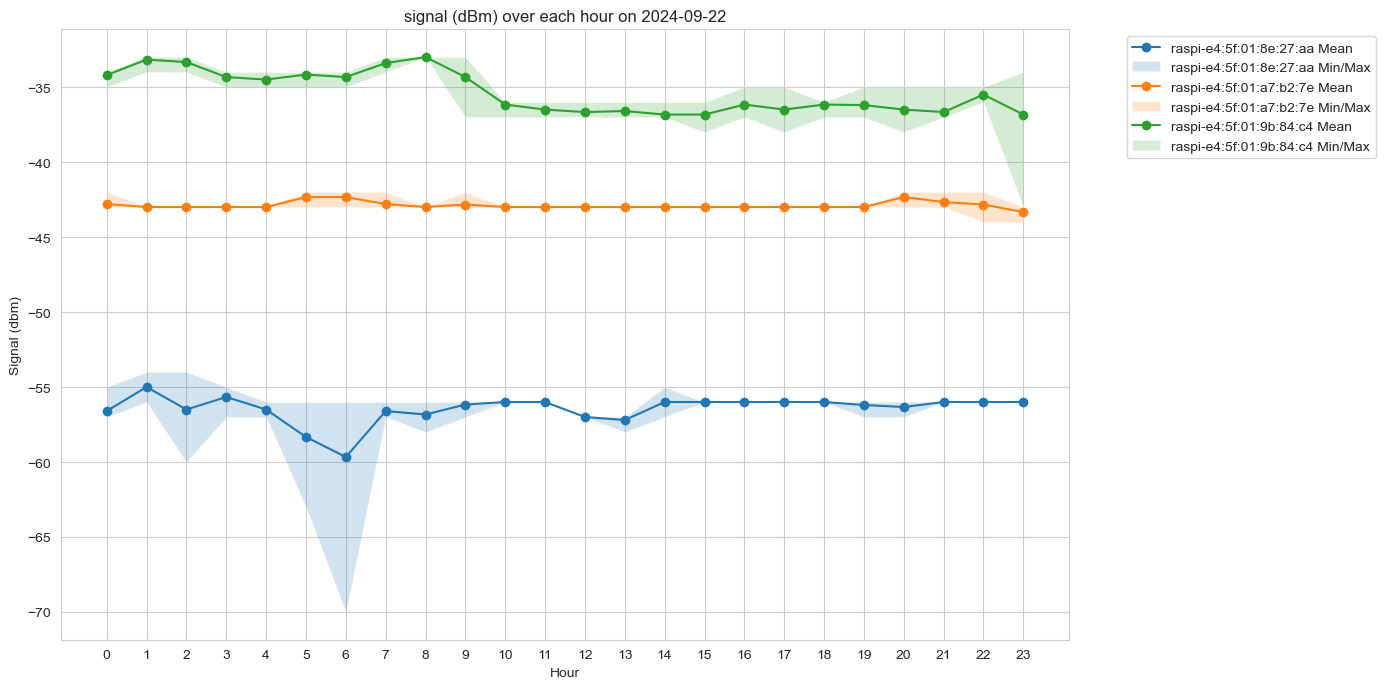

In [37]:
# signal strength over time in September 22, 2024
plot_within_day(
    df,
    2024,
    9,
    22,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)

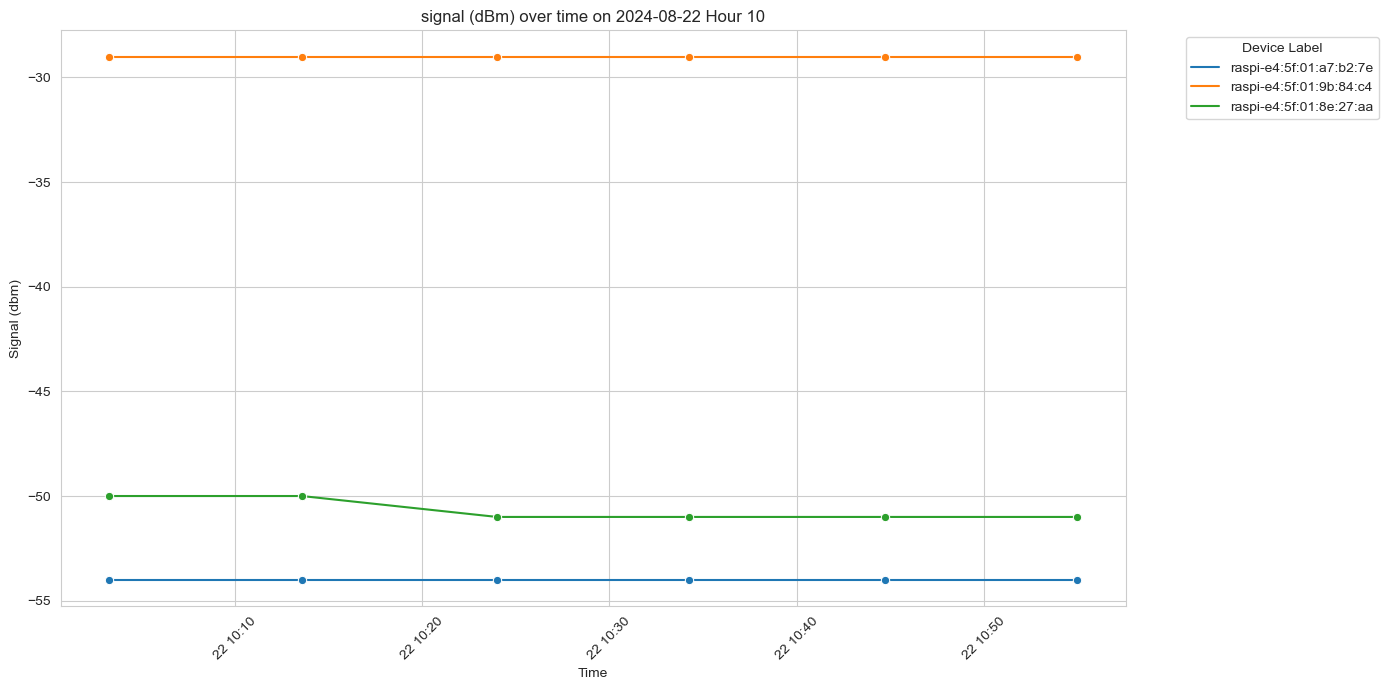

In [38]:
# signal strength over time in 10:00 AM, September 22, 2024
plot_within_hour(
    df,
    2024,
    8,
    22,
    10,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"],
)